# 6.	Download a dataset about website visitors (for example, the Online Shoppers dataset) and train a classification model to predict whether a visitor will make a purchase.

# Data Info

In [1]:
!pip3 install -U ucimlrepo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

url = "https://archive.ics.uci.edu/static/public/468/data.csv"
df = pd.read_csv(url)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

#Let's look at the correlations between features

<ipython-input-2-0a611a359d86>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


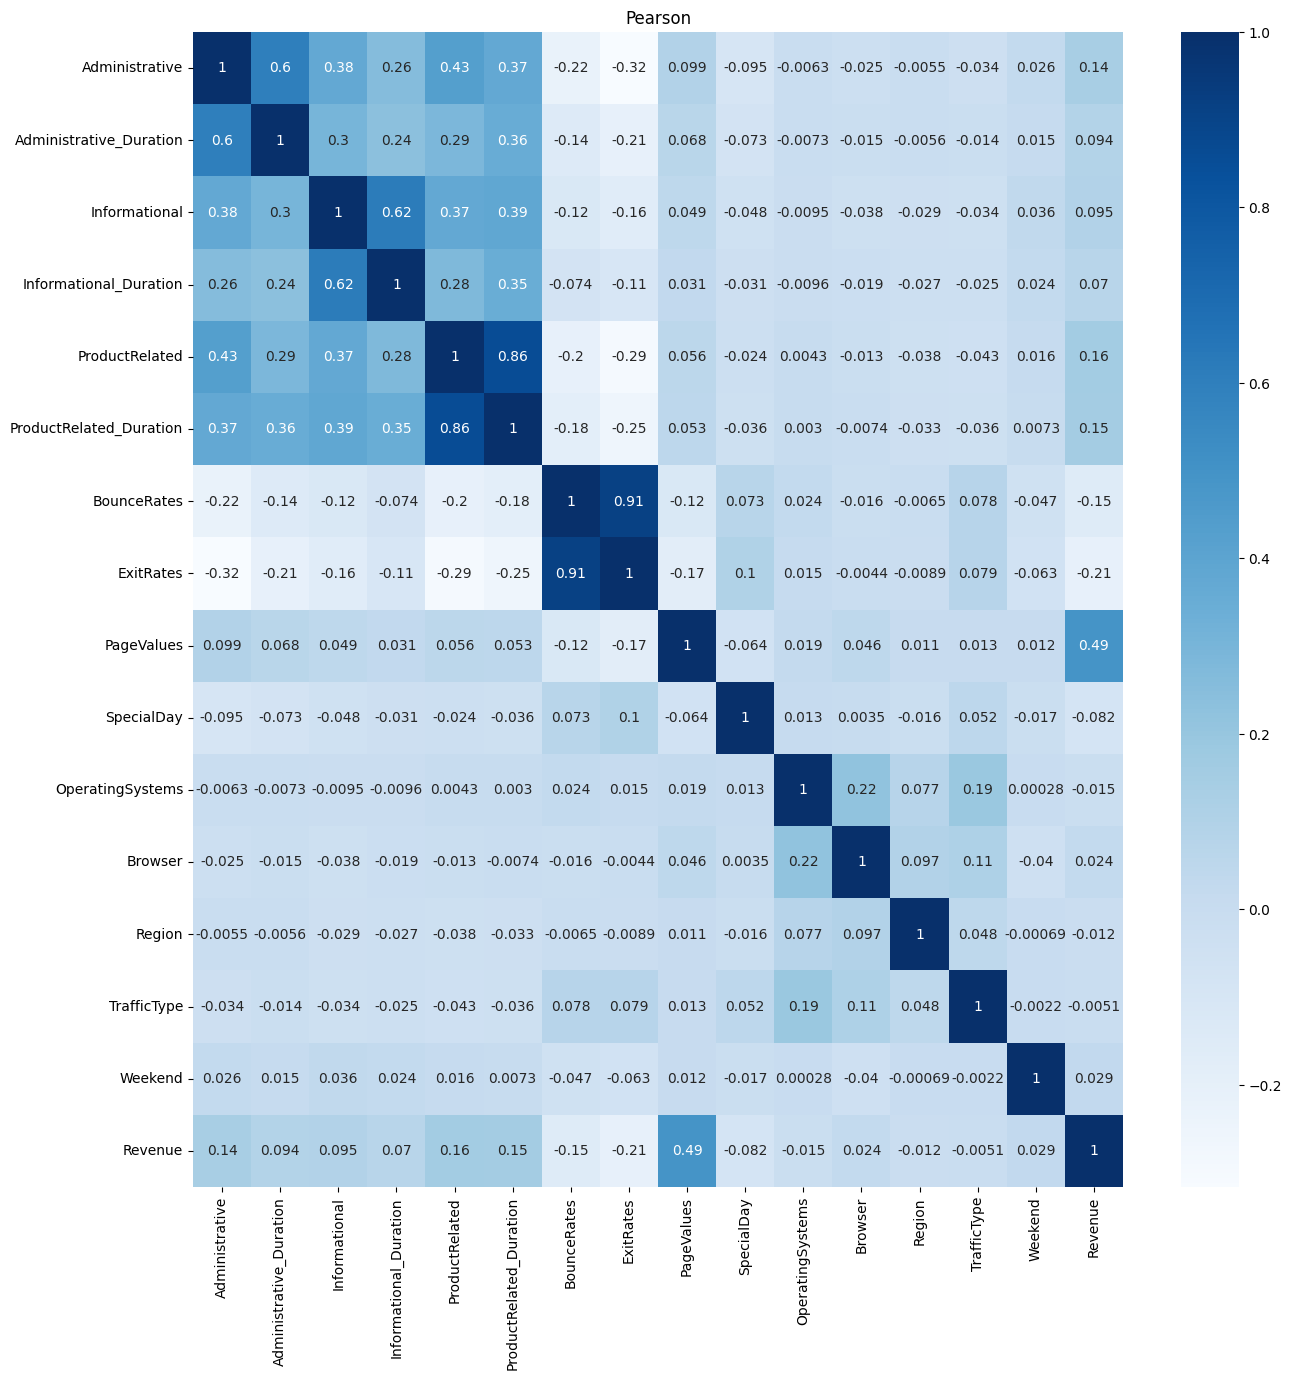

In [2]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.title("Pearson")
plt.show()

# Let's look at the distribution of the target variable
We see that the data is not balanced, since the number of objects with Revenue = 0 is about 5.5 times higher than the number of objects with Revenue = 1. This means that we need to be more careful in choosing metrics when evaluating the quality of models. For example, accuracy will not be the most informative metric here.

False    10422
True      1908
Name: Revenue, dtype: int64


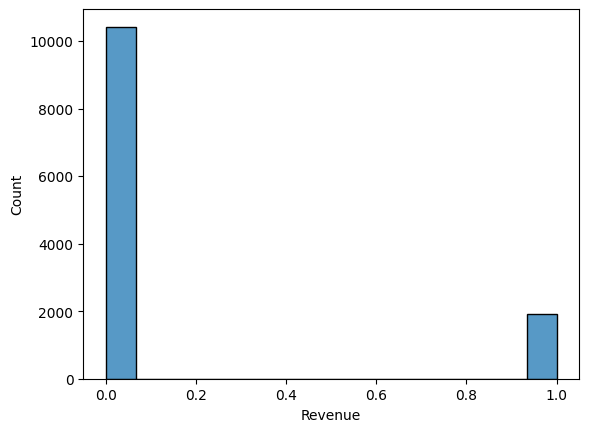

In [3]:
sns.histplot(df['Revenue'])
print(df['Revenue'].value_counts())

# It can be seen that new users make purchases more often than others, and regular users less often.

VisitorType -> object


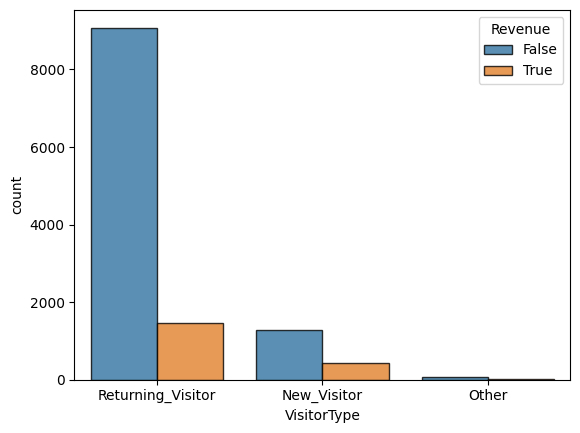

In [4]:
print('VisitorType ->', df['VisitorType'].dtype)
sns.countplot(df,
              x="VisitorType",
              hue="Revenue",
              edgecolor="black",
              alpha=0.8)
plt.show()

# As can be seen from the tests and tables below, purchases are made more often in the fall, especially in November.

Month -> object


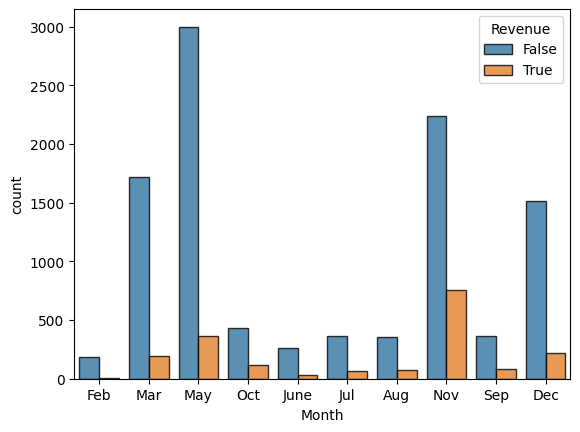

In [5]:
print('Month ->', df['Month'].dtype)
sns.countplot(df,
              x="Month",
              hue="Revenue",
              edgecolor="black",
              alpha=0.8)
plt.show()

Mean Revenue for objects with PageValues = 0: 0.0385
Mean Revenue for objects with PageValues > 0: 0.5634


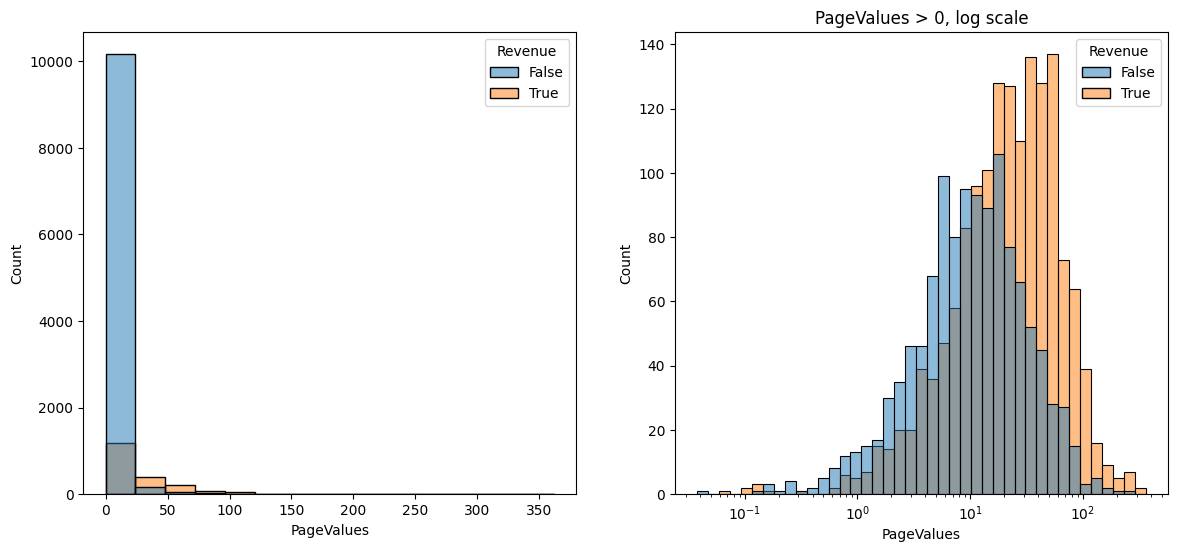

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(df,
             x='PageValues',
             hue="Revenue",
             multiple="layer",
             ax=axs[0]
            )

sns.histplot(df[df['PageValues'] > 0],
             x='PageValues',
             hue="Revenue",
             multiple="layer",
             log_scale=True,
             ax=axs[1]
            )
axs[1].set_title('PageValues > 0, log scale')

print(
    f"Mean Revenue for objects with PageValues = 0: {round(df.loc[df['PageValues'] == 0, ['Revenue']].mean()[0], 4)}"
)
print(
    f"Mean Revenue for objects with PageValues > 0: {round(df.loc[df['PageValues'] > 0, ['Revenue']].mean()[0], 4)}"
)

plt.show()

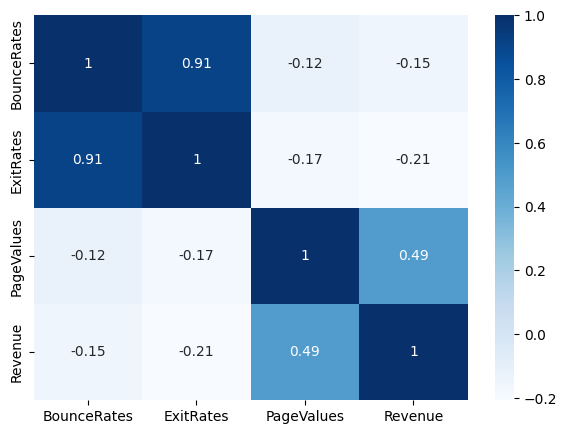

In [7]:
corr = df[['BounceRates', 'ExitRates', 'PageValues', 'Revenue']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [8]:
print('SpecialDay ->', df['SpecialDay'].dtype)
print(
    f"Mean Revenue for objects with SpecialDay = 0: {df.loc[df['SpecialDay'] == 0, ['Revenue']].mean()[0]}"
)
print(
    f"Mean Revenue for objects with SpecialDay > 0: {df.loc[df['SpecialDay'] > 0, ['Revenue']].mean()[0]}"
)

SpecialDay -> float64
Mean Revenue for objects with SpecialDay = 0: 0.16526762343171766
Mean Revenue for objects with SpecialDay > 0: 0.06155075939248601


# Data Preparation

In [9]:
# transforming object types
label_encoder = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = label_encoder.fit_transform(df[column])

#making task as binary classification
y = (df['Revenue']> np.median(df['Revenue'])).astype(int)
X = df.drop('Revenue', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVC

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1)
model.fit(X_train, y_train)

SVCpred = model.predict(X_test)

print("Quality metrics:")
print(classification_report(y_test, SVCpred))

conf_matrix = confusion_matrix(y_test, SVCpred)
print("Error matrix:")
print(conf_matrix)

SVCaccuracy = accuracy_score(y_test, SVCpred)
print(f"Model accuracy: {SVCaccuracy}")

SVCROCAUS = roc_auc_score(y_test, SVCpred)
print(f"ROC AUS: {SVCROCAUS}")

Quality metrics:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93      2055
           1       0.72      0.36      0.48       411

    accuracy                           0.87      2466
   macro avg       0.80      0.67      0.70      2466
weighted avg       0.86      0.87      0.85      2466

Error matrix:
[[1996   59]
 [ 261  150]]
Model accuracy: 0.870235198702352
ROC AUS: 0.6681265206812652


# KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
KNNpred = model_knn.predict(X_test)

print("Quality metrics:")
print(classification_report(y_test, KNNpred))

conf_matrix = confusion_matrix(y_test, KNNpred)
print("Error matrix:")
print(conf_matrix)

KNNaccuracy = accuracy_score(y_test, KNNpred)
print(f"Model accuracy: {KNNaccuracy}")

KNNROCAUS = roc_auc_score(y_test, KNNpred)
print(f"ROC AUS: {KNNROCAUS}")

Quality metrics:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2055
           1       0.68      0.36      0.47       411

    accuracy                           0.87      2466
   macro avg       0.78      0.66      0.70      2466
weighted avg       0.85      0.87      0.85      2466

Error matrix:
[[1986   69]
 [ 263  148]]
Model accuracy: 0.8653690186536902
ROC AUS: 0.6632603406326034


# Naive Bayes

In [12]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
NBpred = model_nb.predict(X_test)

print("Quality metrics:")
print(classification_report(y_test, NBpred))

conf_matrix = confusion_matrix(y_test, NBpred)
print("Error matrix:")
print(conf_matrix)

NBaccuracy = accuracy_score(y_test, NBpred)
print(f"Models accuracy: {NBaccuracy}")

NBROCAUS = roc_auc_score(y_test, NBpred)
print(f"ROC AUS: {NBROCAUS}")

Quality metrics:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87      2055
           1       0.42      0.69      0.52       411

    accuracy                           0.79      2466
   macro avg       0.68      0.75      0.69      2466
weighted avg       0.84      0.79      0.81      2466

Error matrix:
[[1666  389]
 [ 127  284]]
Models accuracy: 0.7907542579075426
ROC AUS: 0.7508515815085158


In [13]:
print('Accuracy')
acc = [SVCaccuracy, KNNaccuracy, NBaccuracy]
method = ['SVC', 'KNN', 'NB']
result = list(zip(method, acc))

for variable, value in result:
    print(f'{variable}: {value}')

print('ROCAUS')
rocaus = [SVCROCAUS, KNNROCAUS, NBROCAUS]
method = ['SVC', 'KNN', 'NB']
result = list(zip(method, rocaus))

for variable, value in result:
    print(f'{variable}: {value}')

Accuracy
SVC: 0.870235198702352
KNN: 0.8653690186536902
NB: 0.7907542579075426
ROCAUS
SVC: 0.6681265206812652
KNN: 0.6632603406326034
NB: 0.7508515815085158
